In [2]:
import pandas as pd
import numpy as np
import pickle

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
df_clean = pd.read_csv("../data/processed/diabetes_clean.csv")
df_clean.shape


(768, 9)

In [4]:
X = df_clean.drop("Outcome", axis=1)
y = df_clean["Outcome"]

X.shape, y.shape


((768, 8), (768,))

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.30,
    random_state=42,
    stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    random_state=42,
    stratify=y_temp
)

print("Train:", X_train.shape, y_train.shape)
print("Val:  ", X_val.shape, y_val.shape)
print("Test: ", X_test.shape, y_test.shape)


Train: (537, 8) (537,)
Val:   (115, 8) (115,)
Test:  (116, 8) (116,)


In [6]:
with open("../models/scaler.pkl", "rb") as f:
    scaler = pickle.load(f)


In [7]:
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

X_train_scaled.shape, X_val_scaled.shape, X_test_scaled.shape


((537, 8), (115, 8), (116, 8))

In [8]:
model = keras.Sequential([
    layers.Input(shape=(X_train_scaled.shape[1],)),  # 8 features
    layers.Dense(32, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(8, activation="relu"),
    layers.Dense(1, activation="sigmoid")  # binary classification
])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 961 (3.75 KB)

 Trainable params: 961 (3.75 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [10]:
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)


In [11]:
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.6574 - loss: 0.6488 - val_accuracy: 0.6609 - val_loss: 0.6104
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6611 - loss: 0.5851 - val_accuracy: 0.6783 - val_loss: 0.5653
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6797 - loss: 0.5468 - val_accuracy: 0.7043 - val_loss: 0.5366
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7188 - loss: 0.5182 - val_accuracy: 0.6957 - val_loss: 0.5197
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7393 - loss: 0.4997 - val_accuracy: 0.6870 - val_loss: 0.5081
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7635 - loss: 0.4863 - val_accuracy: 0.7043 - val_loss: 0.5007
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7709 - loss: 0.4724 - val_accuracy: 0.7043 - val_loss: 0.4992
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7765 - loss: 0.4627 - val_accuracy: 0.6957 

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

y_val_proba = model.predict(X_val_scaled).ravel()
y_val_pred = (y_val_proba >= 0.5).astype(int)

dl_metrics = {
    "accuracy": accuracy_score(y_val, y_val_pred),
    "precision": precision_score(y_val, y_val_pred),
    "recall": recall_score(y_val, y_val_pred),
    "f1": f1_score(y_val, y_val_pred),
    "roc_auc": roc_auc_score(y_val, y_val_proba)
}

dl_metrics


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


{'accuracy': 0.7043478260869566,
 'precision': 0.59375,
 'recall': 0.475,
 'f1': 0.5277777777777778,
 'roc_auc': 0.7983333333333333}

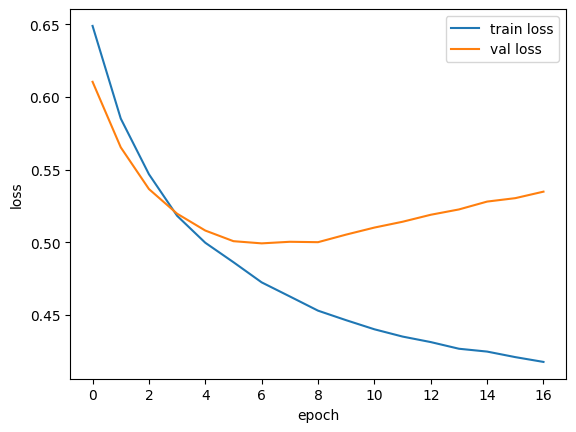

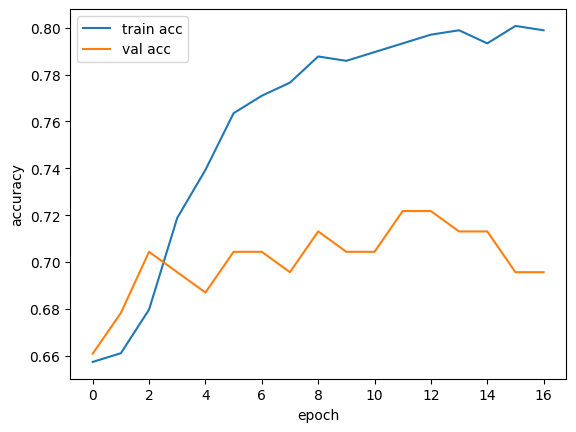

In [13]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(history.history["accuracy"], label="train acc")
plt.plot(history.history["val_accuracy"], label="val acc")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()


In [14]:
model.save("../models/deep_learning_model.h5")
print("✅ Saved deep_learning_model.h5")


✅ Saved deep_learning_model.h5
